# Tutorial: Goal 1 - Investigate Cosine Similarity

This tutorial guides you through investigating cosine similarity in perturbation prediction. We'll explore:

1. What are embeddings and cosine similarity?
2. How to compute pseudobulk expression changes
3. How to construct gene and perturbation embeddings
4. How to compute similarity in embedding space vs expression space
5. How similarity relates to prediction difficulty

## Dataset

We'll use the **Adamson dataset** throughout this tutorial (smallest, fastest dataset).


## 1. Introduction

**Cosine Similarity** is a measure of similarity between two vectors. In perturbation prediction, we use it to:
- Measure how similar two perturbations are in embedding space
- Understand if similar perturbations have similar expression changes
- Investigate whether embedding space captures biological relationships

**Embeddings** are dense vector representations that encode information about:
- **Gene embeddings (A)**: Encode gene properties (e.g., co-expression patterns)
- **Perturbation embeddings (B)**: Encode perturbation properties (e.g., target genes, functional classes)

The key question: **Does similarity in embedding space correlate with similarity in expression space?**


## 2. Setup

Let's start by importing libraries and setting up paths.


In [ ]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import json
import warnings
warnings.filterwarnings('ignore')

# Set up paths (relative to evaluation_framework directory)
NOTEBOOK_DIR = Path.cwd()
EVAL_FRAMEWORK_DIR = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "tutorials" else NOTEBOOK_DIR
if NOTEBOOK_DIR.name == "tutorials":
    sys.path.insert(0, str(EVAL_FRAMEWORK_DIR / "src"))

# Dataset paths
ADAMSON_DATA_PATH = EVAL_FRAMEWORK_DIR.parent / "paper" / "benchmark" / "data" / "gears_pert_data" / "adamson" / "perturb_processed.h5ad"
SPLIT_CONFIG_PATH = EVAL_FRAMEWORK_DIR / "results" / "goal_2_baselines" / "splits" / "adamson_split_seed1.json"
OUTPUT_DIR = EVAL_FRAMEWORK_DIR / "tutorials" / "outputs"

# Create output directory if it doesn't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Ask user: Use real data or synthetic data?
print("="*70)
print("DATA SOURCE SELECTION")
print("="*70)
print("Choose a data source:")
print("  1. Real data: Load from Adamson dataset (requires data download)")
print("  2. Synthetic data: Generate synthetic data (no downloads required)")
print()
USE_REAL_DATA = input("Enter choice (1 for real data, 2 for synthetic): ").strip()
USE_REAL_DATA = USE_REAL_DATA == "1" or USE_REAL_DATA.lower() == "real"

if USE_REAL_DATA:
    print("\n✓ Using REAL DATA")
    print(f"  Adamson data: {ADAMSON_DATA_PATH}")
    print(f"  Split config: {SPLIT_CONFIG_PATH}")
    print(f"  Data exists: {ADAMSON_DATA_PATH.exists()}")
    print(f"  Split exists: {SPLIT_CONFIG_PATH.exists()}")
    if not ADAMSON_DATA_PATH.exists() or not SPLIT_CONFIG_PATH.exists():
        print("\n⚠ WARNING: Required files not found. Switching to synthetic data.")
        USE_REAL_DATA = False
else:
    print("\n✓ Using SYNTHETIC DATA (no downloads required)")


Adamson data: /Users/samuelminer/Documents/classes/nih_research/linear_perturbation_prediction-Paper/paper/benchmark/data/gears_pert_data/adamson/perturb_processed.h5ad
Split config: /Users/samuelminer/Documents/classes/nih_research/linear_perturbation_prediction-Paper/evaluation_framework/results/goal_2_baselines/splits/adamson_split_seed1.json
Data exists: True
Split exists: True


## 3. Core Concepts

### 3.1 What are Embeddings?

**Embeddings** are low-dimensional vector representations that capture important features:
- **Gene embeddings**: Encode which genes are co-expressed, functionally related, or share regulatory patterns
- **Perturbation embeddings**: Encode which perturbations target similar genes or produce similar effects

### 3.2 What is Cosine Similarity?

**Cosine similarity** measures the angle between two vectors:
- Range: -1 (opposite) to 1 (identical)
- 0 means orthogonal (unrelated)
- Formula: cos(θ) = (A · B) / (||A|| ||B||)

It's particularly useful for embeddings because it's scale-invariant: only the direction matters, not the magnitude.

### 3.3 Pseudobulk Expression Changes

**Pseudobulk** means aggregating single-cell data by condition:
- For each perturbation: average expression across all cells
- Subtract control: Y_{gene, pert} = mean(expression in pert) - mean(expression in control)
- Result: Y matrix (genes × perturbations) representing expression changes


## 4. Load Data and Compute Y Matrix

Let's load the Adamson dataset and compute pseudobulk expression changes.


In [ ]:
if USE_REAL_DATA:
    # Load real data
    adata = ad.read_h5ad(ADAMSON_DATA_PATH)
    print(f"AnnData shape: {adata.shape} (cells × genes)")
    print(f"Conditions: {adata.obs['condition'].nunique()} unique conditions")

    # Load split configuration
    with open(SPLIT_CONFIG_PATH, 'r') as f:
        split_config = json.load(f)

    print(f"\nSplit configuration:")
    for split_name, perts in split_config.items():
        print(f"  {split_name}: {len(perts)} perturbations")
        
    train_perts = split_config.get('train', [])
    test_perts = split_config.get('test', [])
    val_perts = split_config.get('val', [])

    print(f"\nTrain: {len(train_perts)}, Test: {len(test_perts)}, Val: {len(val_perts)}")
else:
    # Generate synthetic data
    print("Generating synthetic AnnData...")
    n_cells = 5000
    n_genes = 2000
    n_conditions = 87
    seed = 42
    
    np.random.seed(seed)
    
    # Generate synthetic expression data
    X = np.random.lognormal(mean=2, sigma=1, size=(n_cells, n_genes))
    
    # Create condition labels
    condition_names = [f"pert_{i}" for i in range(n_conditions-1)] + ["ctrl"]
    conditions = np.random.choice(condition_names, size=n_cells)
    
    # Create synthetic AnnData
    adata = ad.AnnData(X)
    adata.var_names = [f"ENSG{i:010d}" for i in range(n_genes)]
    adata.obs["condition"] = conditions
    
    # Create synthetic split configuration
    train_perts = [f"pert_{i}" for i in range(61)]
    test_perts = [f"pert_{i}" for i in range(61, 73)]
    val_perts = [f"pert_{i}" for i in range(73, 87)]
    
    split_config = {
        "train": train_perts,
        "test": test_perts,
        "val": val_perts,
    }
    
    print(f"Synthetic AnnData shape: {adata.shape} (cells × genes)")
    print(f"Conditions: {len(condition_names)} unique conditions")
    print(f"\nSplit configuration:")
    for split_name, perts in split_config.items():
        print(f"  {split_name}: {len(perts)} perturbations")
    print(f"\nTrain: {len(train_perts)}, Test: {len(test_perts)}, Val: {len(val_perts)}")


AnnData shape: (68603, 5060) (cells × genes)
Conditions: 87 unique conditions

Split configuration:
  train: 61 perturbations
  test: 12 perturbations
  val: 14 perturbations

Train: 61, Test: 12, Val: 14


In [ ]:
# Compute pseudobulk expression changes (Y matrix)
# This is the same computation used in baseline_runner.compute_pseudobulk_expression_changes

# Filter to valid conditions
all_conditions = []
for conditions in split_config.values():
    all_conditions.extend(conditions)
all_conditions = list(set(all_conditions))

adata_filtered = adata[adata.obs["condition"].isin(all_conditions)].copy()

# Clean condition names (remove +ctrl suffix if present)
adata_filtered.obs["clean_condition"] = (
    adata_filtered.obs["condition"].astype(str).str.replace(r"\+ctrl", "", regex=True)
)

# Compute baseline (mean expression in control)
ctrl_mask = adata_filtered.obs["condition"] == "ctrl"
if ctrl_mask.sum() == 0:
    raise ValueError("No control condition found in data")

baseline = np.asarray(adata_filtered.X[ctrl_mask].mean(axis=0)).ravel()
print(f"Baseline shape: {baseline.shape} (mean expression across {ctrl_mask.sum()} control cells)")

# Pseudobulk by condition
unique_conditions = adata_filtered.obs["clean_condition"].unique()
pseudobulk_data = []
condition_labels = []

for cond in unique_conditions:
    cond_mask = adata_filtered.obs["clean_condition"] == cond
    if cond_mask.sum() == 0:
        continue
    
    # Average expression within condition
    cond_expr = adata_filtered.X[cond_mask]
    if hasattr(cond_expr, "toarray"):
        cond_expr = cond_expr.toarray()
    mean_expr = np.asarray(cond_expr.mean(axis=0)).ravel()
    
    # Compute change from baseline
    change = mean_expr - baseline
    
    pseudobulk_data.append(change)
    condition_labels.append(cond)

# Create Y matrix (genes × perturbations)
Y = np.vstack(pseudobulk_data).T  # Transpose to get genes × perts

# Create DataFrame
gene_names = adata_filtered.var_names.tolist()
Y_df = pd.DataFrame(Y, index=gene_names, columns=condition_labels)

print(f"\nY matrix shape: {Y_df.shape} (genes × perturbations)")
print(f"First few genes: {gene_names[:5]}")
print(f"First few perturbations: {condition_labels[:5]}")
print(f"\nY matrix statistics:")
print(Y_df.describe().T.head(10))

# Save outputs if using real data (for use in subsequent notebooks)
if USE_REAL_DATA:
    output_file = OUTPUT_DIR / "goal_1_Y_matrix.csv"
    Y_df.to_csv(output_file)
    print(f"\n✓ Saved Y matrix to: {output_file}")


Baseline shape: (5060,) (mean expression across 24263 control cells)

Y matrix shape: (5060, 87) (genes × perturbations)
First few genes: ['ENSG00000228463', 'ENSG00000272438', 'ENSG00000230699', 'ENSG00000223764', 'ENSG00000187634']
First few perturbations: ['CREB1', 'ctrl', 'ZNF326', 'BHLHE40', 'DDIT3']

Y matrix statistics:
             CREB1          ctrl       ZNF326      BHLHE40        DDIT3  \
count  5060.000000  5.060000e+03  5060.000000  5060.000000  5060.000000   
mean     -0.039891 -9.520654e-09    -0.041885    -0.036847    -0.040410   
std       0.089557  1.670432e-06     0.093299     0.094131     0.090201   
min      -2.081289 -2.861023e-05    -2.127524    -2.105235    -2.102503   
25%      -0.060285 -1.490116e-08    -0.063635    -0.055077    -0.060393   
50%      -0.006288  0.000000e+00    -0.006993    -0.004791    -0.007265   
75%      -0.000438  3.725290e-09    -0.000457    -0.000324    -0.000510   
max       0.746014  2.622604e-05     0.827673     0.806888     0.791973

## 5. Construct Embeddings

Now let's construct gene embeddings (A) and perturbation embeddings (B) using PCA. We'll use the self-trained baseline (PCA on training data).


In [4]:
# Split Y into train and test
# Clean condition names in split_config
clean_split_config = {}
for split_name, conditions in split_config.items():
    clean_split_config[split_name] = [
        cond.replace("+ctrl", "") if "+ctrl" in cond else cond
        for cond in conditions
    ]

train_perts_clean = [p for p in clean_split_config.get("train", []) if p in Y_df.columns]
test_perts_clean = [p for p in clean_split_config.get("test", []) if p in Y_df.columns]

Y_train = Y_df[train_perts_clean]
Y_test = Y_df[test_perts_clean] if test_perts_clean else pd.DataFrame()

print(f"Y_train shape: {Y_train.shape} (genes × train perturbations)")
print(f"Y_test shape: {Y_test.shape} (genes × test perturbations)")

# Parameters
pca_dim = 10
seed = 1


Y_train shape: (5060, 61) (genes × train perturbations)
Y_test shape: (5060, 12) (genes × test perturbations)


In [5]:
# Construct gene embeddings (A) using PCA
# A: genes × pca_dim
# We do PCA on Y_train (genes × train_perts), treating genes as observations
gene_pca = PCA(n_components=pca_dim, random_state=seed)
A = gene_pca.fit_transform(Y_train.values)  # genes × pca_dim

print(f"Gene embeddings (A) shape: {A.shape} (genes × {pca_dim})")
print(f"Explained variance ratio: {gene_pca.explained_variance_ratio_[:5]}")
print(f"Cumulative explained variance: {gene_pca.explained_variance_ratio_.cumsum()[:5]}")

# Construct perturbation embeddings (B) using PCA
# B_train: pca_dim × train_perts (we transpose to get this format)
pert_pca = PCA(n_components=pca_dim, random_state=seed)
pert_emb_train = pert_pca.fit_transform(Y_train.values.T)  # train_perts × pca_dim
B_train = pert_emb_train.T  # pca_dim × train_perts

# Transform test perturbations if available
if not Y_test.empty:
    pert_emb_test = pert_pca.transform(Y_test.values.T)  # test_perts × pca_dim
    B_test = pert_emb_test.T  # pca_dim × test_perts
else:
    B_test = None

print(f"\nPerturbation embeddings (B_train) shape: {B_train.shape} (pca_dim × train_perts)")
if B_test is not None:
    print(f"Perturbation embeddings (B_test) shape: {B_test.shape} (pca_dim × test_perts)")
print(f"Explained variance ratio: {pert_pca.explained_variance_ratio_[:5]}")
print(f"Cumulative explained variance: {pert_pca.explained_variance_ratio_.cumsum()[:5]}")


Gene embeddings (A) shape: (5060, 10) (genes × 10)
Explained variance ratio: [0.61772263 0.14744689 0.04341727 0.02979902 0.02520056]
Cumulative explained variance: [0.61772263 0.7651695  0.8085868  0.8383858  0.86358637]

Perturbation embeddings (B_train) shape: (10, 61) (pca_dim × train_perts)
Perturbation embeddings (B_test) shape: (10, 12) (pca_dim × test_perts)
Explained variance ratio: [0.32693478 0.26617053 0.0674919  0.05201699 0.03762968]
Cumulative explained variance: [0.32693478 0.5931053  0.6605972  0.7126142  0.75024384]


## 6. Compute Similarity in Embedding Space

Let's compute cosine similarity between test and training perturbations in embedding space.


In [6]:
if B_test is not None and len(test_perts_clean) > 0:
    # Compute cosine similarity between test and train perturbations
    # B_train: (pca_dim × train_perts) -> transpose to (train_perts × pca_dim)
    # B_test: (pca_dim × test_perts) -> transpose to (test_perts × pca_dim)
    B_train_T = B_train.T  # train_perts × pca_dim
    B_test_T = B_test.T  # test_perts × pca_dim
    
    # Compute similarity matrix (test_perts × train_perts)
    embedding_similarities = cosine_similarity(B_test_T, B_train_T)
    
    print(f"Embedding similarity matrix shape: {embedding_similarities.shape}")
    print(f"Similarity range: [{embedding_similarities.min():.3f}, {embedding_similarities.max():.3f}]")
    print(f"\nExample: Similarity of first test pert to all train perts:")
    print(f"  Mean: {embedding_similarities[0].mean():.3f}")
    print(f"  Max: {embedding_similarities[0].max():.3f}")
    print(f"  Min: {embedding_similarities[0].min():.3f}")
    
    # For each test perturbation, find top K most similar training perturbations
    k = 5
    top_k_indices = np.argsort(embedding_similarities, axis=1)[:, -k:][:, ::-1]
    top_k_similarities = np.sort(embedding_similarities, axis=1)[:, -k:][:, ::-1]
    
    print(f"\nTop {k} most similar training perturbations for first test perturbation:")
    for i, (idx, sim) in enumerate(zip(top_k_indices[0], top_k_similarities[0])):
        print(f"  {i+1}. {train_perts_clean[idx]}: similarity = {sim:.3f}")
else:
    print("No test perturbations available")
    embedding_similarities = None
    top_k_similarities = None


Embedding similarity matrix shape: (12, 61)
Similarity range: [-0.861, 0.997]

Example: Similarity of first test pert to all train perts:
  Mean: -0.158
  Max: 0.983
  Min: -0.829

Top 5 most similar training perturbations for first test perturbation:
  1. TIMM44: similarity = 0.983
  2. QARS: similarity = 0.943
  3. FARSB: similarity = 0.936
  4. IARS2: similarity = 0.935
  5. SARS: similarity = 0.930


## 7. Compute Similarity in Expression Space

Now let's compute cosine similarity in expression space (using Y matrix directly) and compare it to embedding space similarity.


In [7]:
if not Y_test.empty:
    # Compute cosine similarity in expression space
    # Y_train: (genes × train_perts) -> transpose to (train_perts × genes)
    # Y_test: (genes × test_perts) -> transpose to (test_perts × genes)
    Y_train_T = Y_train.values.T  # train_perts × genes
    Y_test_T = Y_test.values.T  # test_perts × genes
    
    # Compute similarity matrix (test_perts × train_perts)
    expression_similarities = cosine_similarity(Y_test_T, Y_train_T)
    
    print(f"Expression similarity matrix shape: {expression_similarities.shape}")
    print(f"Similarity range: [{expression_similarities.min():.3f}, {expression_similarities.max():.3f}]")
    print(f"\nExample: Similarity of first test pert to all train perts:")
    print(f"  Mean: {expression_similarities[0].mean():.3f}")
    print(f"  Max: {expression_similarities[0].max():.3f}")
    print(f"  Min: {expression_similarities[0].min():.3f}")
    
    # Top K most similar in expression space
    top_k_expr_indices = np.argsort(expression_similarities, axis=1)[:, -k:][:, ::-1]
    top_k_expr_similarities = np.sort(expression_similarities, axis=1)[:, -k:][:, ::-1]
    
    print(f"\nTop {k} most similar training perturbations in expression space:")
    for i, (idx, sim) in enumerate(zip(top_k_expr_indices[0], top_k_expr_similarities[0])):
        print(f"  {i+1}. {train_perts_clean[idx]}: similarity = {sim:.3f}")
else:
    print("No test perturbations available")
    expression_similarities = None


Expression similarity matrix shape: (12, 61)
Similarity range: [-0.617, 0.972]

Example: Similarity of first test pert to all train perts:
  Mean: 0.534
  Max: 0.913
  Min: -0.383

Top 5 most similar training perturbations in expression space:
  1. TIMM44: similarity = 0.913
  2. EIF2B4: similarity = 0.896
  3. IARS2: similarity = 0.890
  4. QARS: similarity = 0.881
  5. FARSB: similarity = 0.876


## 8. Visualizations

Let's visualize the similarity distributions and compare embedding space vs expression space.


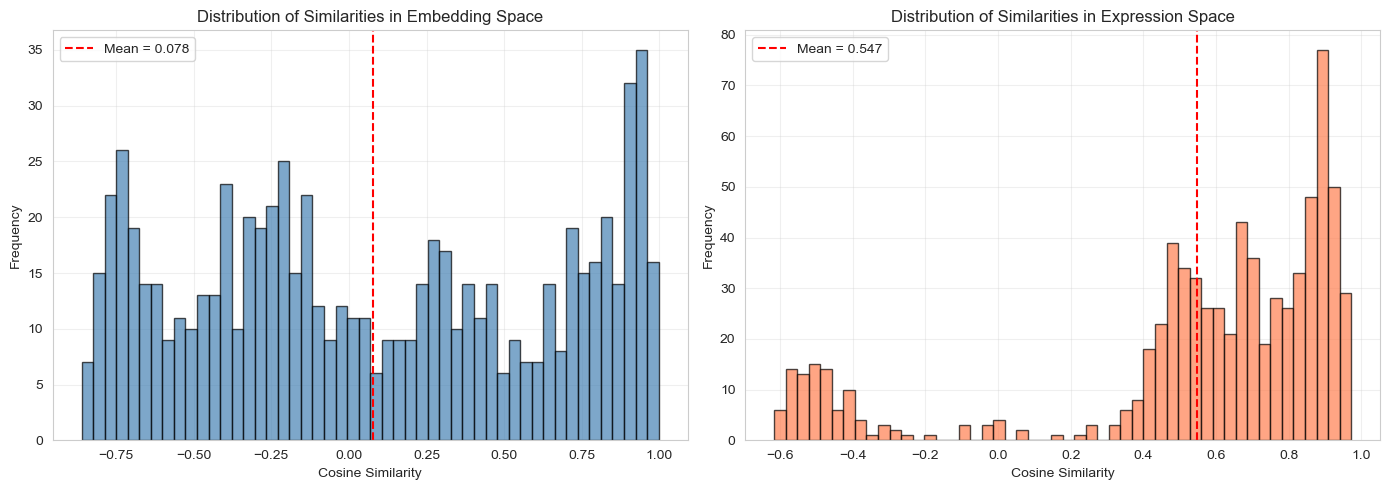

In [8]:
# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

if embedding_similarities is not None and expression_similarities is not None:
    # Plot 1: Distribution of similarities
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Embedding space similarities
    axes[0].hist(embedding_similarities.flatten(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0].set_xlabel('Cosine Similarity')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Similarities in Embedding Space')
    axes[0].axvline(embedding_similarities.mean(), color='red', linestyle='--', label=f'Mean = {embedding_similarities.mean():.3f}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Expression space similarities
    axes[1].hist(expression_similarities.flatten(), bins=50, alpha=0.7, color='coral', edgecolor='black')
    axes[1].set_xlabel('Cosine Similarity')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Similarities in Expression Space')
    axes[1].axvline(expression_similarities.mean(), color='red', linestyle='--', label=f'Mean = {expression_similarities.mean():.3f}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


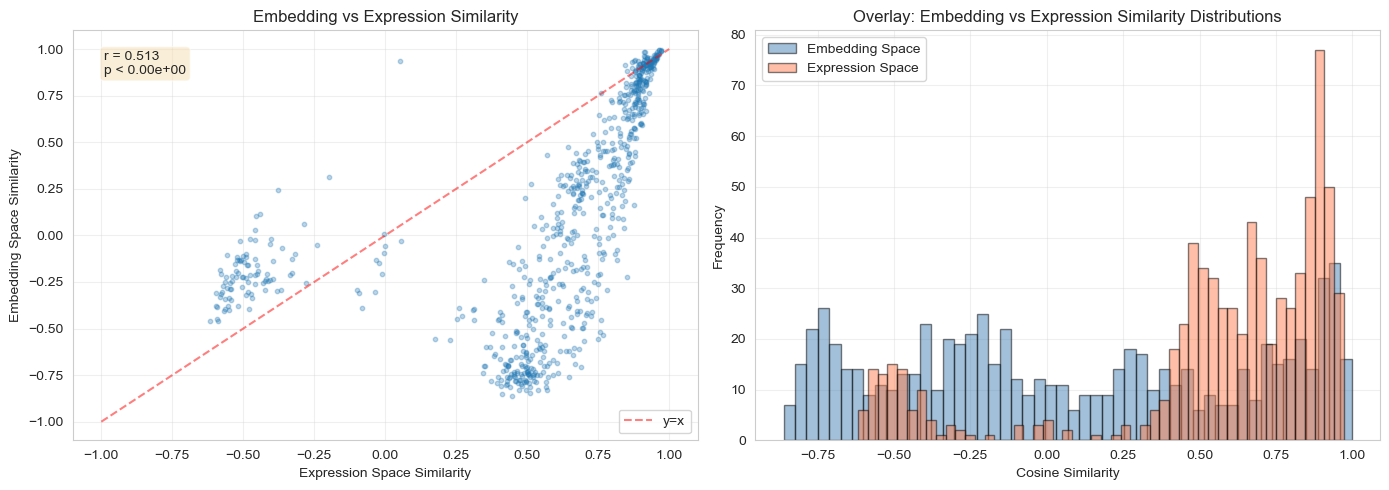


Correlation between embedding and expression similarities: r = 0.513 (p = 0.00e+00)


In [9]:
# Plot 2: Compare embedding vs expression similarity
if embedding_similarities is not None and expression_similarities is not None:
    # Flatten both matrices for comparison
    emb_flat = embedding_similarities.flatten()
    expr_flat = expression_similarities.flatten()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot: embedding vs expression similarity
    axes[0].scatter(expr_flat, emb_flat, alpha=0.3, s=10)
    axes[0].set_xlabel('Expression Space Similarity')
    axes[0].set_ylabel('Embedding Space Similarity')
    axes[0].set_title('Embedding vs Expression Similarity')
    axes[0].plot([-1, 1], [-1, 1], 'r--', alpha=0.5, label='y=x')
    
    # Compute correlation
    from scipy.stats import pearsonr
    corr, p_value = pearsonr(expr_flat, emb_flat)
    axes[0].text(0.05, 0.95, f'r = {corr:.3f}\np < {p_value:.2e}', 
                 transform=axes[0].transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Histogram overlay
    axes[1].hist(emb_flat, bins=50, alpha=0.5, label='Embedding Space', color='steelblue', edgecolor='black')
    axes[1].hist(expr_flat, bins=50, alpha=0.5, label='Expression Space', color='coral', edgecolor='black')
    axes[1].set_xlabel('Cosine Similarity')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Overlay: Embedding vs Expression Similarity Distributions')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nCorrelation between embedding and expression similarities: r = {corr:.3f} (p = {p_value:.2e})")


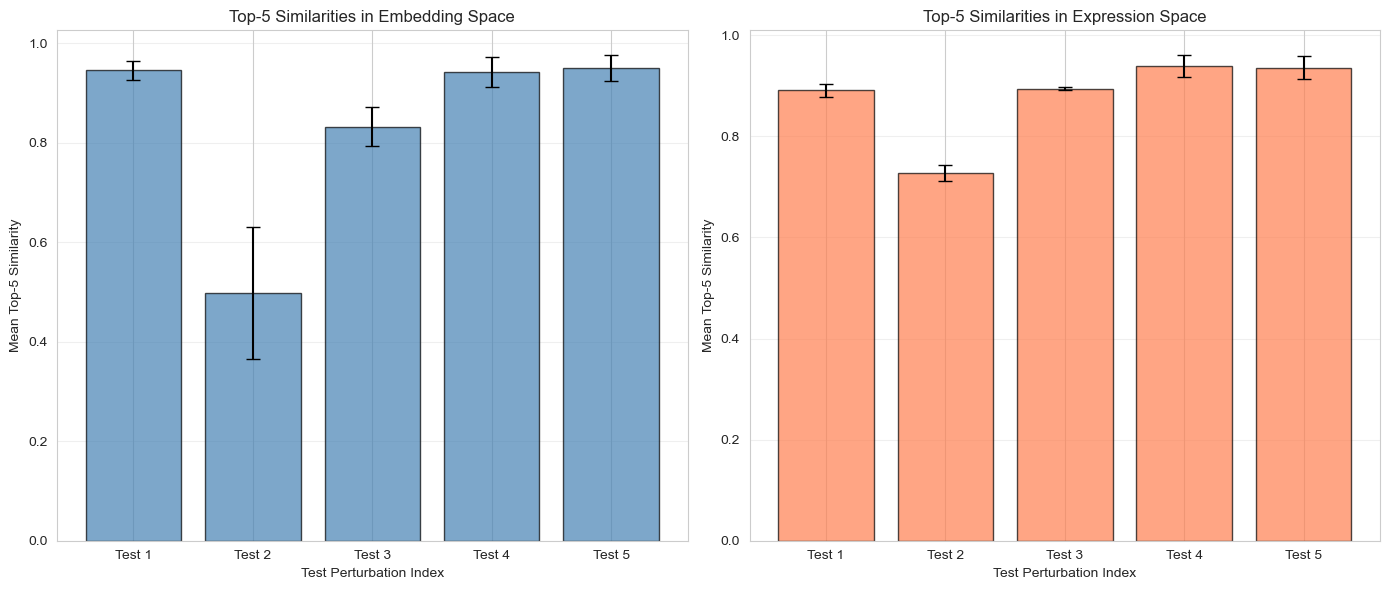

In [10]:
# Plot 3: Top K similarities for each test perturbation
if embedding_similarities is not None and expression_similarities is not None and len(test_perts_clean) > 0:
    n_test = min(len(test_perts_clean), 5)  # Show first 5 test perturbations
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Embedding space top K
    emb_top_k_means = [top_k_similarities[i, :].mean() for i in range(n_test)]
    emb_top_k_stds = [top_k_similarities[i, :].std() for i in range(n_test)]
    
    x_pos = np.arange(n_test)
    axes[0].bar(x_pos, emb_top_k_means, yerr=emb_top_k_stds, alpha=0.7, color='steelblue', edgecolor='black', capsize=5)
    axes[0].set_xlabel('Test Perturbation Index')
    axes[0].set_ylabel(f'Mean Top-{k} Similarity')
    axes[0].set_title(f'Top-{k} Similarities in Embedding Space')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels([f'Test {i+1}' for i in range(n_test)])
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Expression space top K
    expr_top_k_means = [top_k_expr_similarities[i, :].mean() for i in range(n_test)]
    expr_top_k_stds = [top_k_expr_similarities[i, :].std() for i in range(n_test)]
    
    axes[1].bar(x_pos, expr_top_k_means, yerr=expr_top_k_stds, alpha=0.7, color='coral', edgecolor='black', capsize=5)
    axes[1].set_xlabel('Test Perturbation Index')
    axes[1].set_ylabel(f'Mean Top-{k} Similarity')
    axes[1].set_title(f'Top-{k} Similarities in Expression Space')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels([f'Test {i+1}' for i in range(n_test)])
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


## 9. Analysis: Relationship Between Similarity and Prediction Difficulty

The key question: **Does similarity in embedding space help predict expression similarity?**

If embeddings capture biological relationships well, we expect:
- High similarity in embedding space → High similarity in expression space
- Low similarity in embedding space → Low similarity in expression space

From the correlation we computed above, we can see how well embeddings capture expression relationships.


In [11]:
if embedding_similarities is not None and expression_similarities is not None:
    # Summary statistics
    print("Summary Statistics:")
    print("=" * 60)
    print(f"Embedding Space Similarities:")
    print(f"  Mean: {embedding_similarities.mean():.3f}")
    print(f"  Std:  {embedding_similarities.std():.3f}")
    print(f"  Min:  {embedding_similarities.min():.3f}")
    print(f"  Max:  {embedding_similarities.max():.3f}")
    print(f"\nExpression Space Similarities:")
    print(f"  Mean: {expression_similarities.mean():.3f}")
    print(f"  Std:  {expression_similarities.std():.3f}")
    print(f"  Min:  {expression_similarities.min():.3f}")
    print(f"  Max:  {expression_similarities.max():.3f}")
    
    # Correlation
    corr, p_value = pearsonr(embedding_similarities.flatten(), expression_similarities.flatten())
    print(f"\nCorrelation: r = {corr:.3f} (p = {p_value:.2e})")
    
    if corr > 0.5:
        print("\n✅ Strong positive correlation: Embedding space captures expression relationships well!")
    elif corr > 0.3:
        print("\n✓ Moderate correlation: Embedding space captures some expression relationships.")
    else:
        print("\n⚠ Low correlation: Embedding space may not fully capture expression relationships.")


Summary Statistics:
Embedding Space Similarities:
  Mean: 0.078
  Std:  0.573
  Min:  -0.861
  Max:  0.997

Expression Space Similarities:
  Mean: 0.547
  Std:  0.430
  Min:  -0.617
  Max:  0.972

Correlation: r = 0.513 (p = 0.00e+00)

✅ Strong positive correlation: Embedding space captures expression relationships well!


## 10. Summary

### Key Takeaways

1. **Embeddings**: Low-dimensional vector representations that capture important features of genes and perturbations
   - Gene embeddings (A): Capture co-expression and functional relationships
   - Perturbation embeddings (B): Capture similarity in targets and effects

2. **Cosine Similarity**: Measure of similarity between vectors (angle-based, scale-invariant)
   - Range: -1 to 1
   - Useful for comparing embeddings and expression patterns

3. **Similarity Analysis**: 
   - Embedding space similarity measures how similar perturbations are in learned representation
   - Expression space similarity measures how similar perturbations are in actual gene expression changes
   - Correlation between the two indicates whether embeddings capture biological relationships

4. **Pseudobulk**: Aggregating single-cell data by condition to get average expression changes

### Next Steps

In the next tutorial (Goal 2), we'll use these embeddings to build a predictive model:
- Solve Y = A·K·B for the interaction matrix K
- Use K to predict expression changes for new perturbations
- Evaluate how well different embedding sources (PCA, scGPT, random) enable prediction

### Questions to Consider

1. Why might embedding similarity differ from expression similarity?
2. What does a high correlation between embedding and expression similarity mean?
3. How could we use similarity information to improve predictions?

---

**Tutorial completed!** Move on to `tutorial_goal_2_baselines.ipynb` to learn about the linear model and baseline implementation.
